In [130]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import locale
import mibian
import numpy as np

In [131]:
# URL de la página a hacer scraping
url = 'https://www.meff.es/esp/Derivados-Financieros/Ficha/FIEM_MiniIbex_35'

# Realizar la petición HTTP GET a la página
response = requests.get(url)

In [132]:
def obtener_dataframe(response, tipo_tabla):
    """
    Realiza el web scraping y devuelve un dataframe con los datos obtenidos,
    dependiendo si el tipo de tabla es 'opciones' o 'futuros'.
    
    Args:
    - response: La respuesta HTTP obtenida.
    - tipo_tabla: Tipo de la tabla a buscar ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe con los datos de la tabla.
    """
    # Determinar el ID de la tabla y si se necesita manejar el atributo data-tipo
    if tipo_tabla == 'opciones':
        id_tabla = 'tblOpciones'
        es_opcion = True
    elif tipo_tabla == 'futuros':
        id_tabla = 'Contenido_Contenido_tblFuturos'
        es_opcion = False
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        table = soup.find('table', id=id_tabla)
        all_rows_data = []
        
        if table:
            rows = table.find_all('tr', class_='text-right')
            
            for row in rows:
                cells = row.find_all('td')
                row_data = [cell.text.strip() for cell in cells]
                
                if es_opcion:
                    data_tipo = row.get('data-tipo', 'No especificado')
                    row_data.insert(0, data_tipo)
                    
                all_rows_data.append(row_data)
                
            return pd.DataFrame(all_rows_data)
        else:
            print('No se encontró la tabla con el id especificado.')
            return pd.DataFrame()
    else:
        print('Error al realizar la petición HTTP:', response.status_code)
        return pd.DataFrame()

In [133]:
def tratar_dataframe(df, tipo_tabla):
    """
    Transforma el dataframe según si es de opciones o de futuros.
    
    Args:
    - df: Dataframe a transformar.
    - tipo_tabla: Tipo de la tabla ('opciones' o 'futuros').
    
    Returns:
    - Un dataframe transformado.
    """
    if tipo_tabla == 'opciones':
        # Especificar los nombres de columna para opciones
        df.columns = ['Class', 'Strike', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        df['Tipo'] = df['Class'].str[:3]
        df['Fecha'] = pd.to_datetime(df['Class'].str[3:], format='%Y%m%d').dt.strftime('%d-%m-%Y')
        df = df.drop(['Class'], axis=1)
        
        # Transformaciones adicionales para opciones
        df['Strike'] = df['Strike'].str.replace('.', '').str.replace(',', '.').astype(float)
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d-%m-%Y')
        
        # Seleccionando solo las columnas deseadas para opciones
        df = df.loc[:, ['Tipo', 'Fecha', 'Strike', 'Ant']]
        
    elif tipo_tabla == 'futuros':
        # Especificar los nombres de columna para futuros
        df.columns = ['Vencimiento', 'Tipo', 'Buy_ord', 'Buy_vol', 'Buy_price', 'Sell_price', 'Sell_vol', 'Sell_ord', 'Ult', 'Vol', 'Aper', 'Max.', 'Min.','Ant']
        
        # Configurar locale a español
        locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8' if locale.windows_locale is None else 'Spanish')
        df['Vencimiento'] = pd.to_datetime(df['Vencimiento'], format='%d %b %Y')
        df['Ant'] = pd.to_numeric(df['Ant'].str.replace('.', '').str.replace(',', '.'), errors='coerce')
        
        # Seleccionando solo las columnas deseadas para futuros
        df = df.loc[:, ['Vencimiento', 'Ant']]
        
    else:
        print("Tipo de tabla no soportado.")
        return pd.DataFrame()
    
    return df

In [134]:
# Opciones
df_opciones = obtener_dataframe(response, 'opciones')
df_opciones = tratar_dataframe(df_opciones, 'opciones')

In [135]:
# Futuros
df_futuros = obtener_dataframe(response, 'futuros')
df_futuros = tratar_dataframe(df_futuros, 'futuros')

In [136]:
# Filtrar para obtener solo las opciones de compra (calls) y de venta (puts)
df_calls = df_opciones[df_opciones['Tipo'] == 'OCE']
df_puts = df_opciones[df_opciones['Tipo'] == 'OPE']

# Crear un diccionario donde cada fecha es una clave y el valor es el DataFrame correspondiente
calls_por_fecha = {fecha: grupo for fecha, grupo in df_calls.groupby('Fecha')}
puts_por_fecha = {fecha: grupo for fecha, grupo in df_puts.groupby('Fecha')}

# Incluir estos diccionarios bajo las claves 'Call' y 'Put' en el diccionario 'resultados'
resultados = {
    'Call': calls_por_fecha,
    'Put': puts_por_fecha
}


In [137]:
df_futuros

,Vencimiento,Ant
0,2024-04-19,10644.0
1,2024-05-17,10610.0
2,2024-06-21,10617.0


In [138]:
price_sub = df_futuros.loc[0, 'Ant']
rfr = 0
dia_futuro = df_futuros.loc[0, 'Vencimiento']

In [139]:
price_sub

10644.0

In [140]:
df_calls

,Tipo,Fecha,Strike,Ant
1,OCE,2024-04-19,8400.0,2244.0
2,OCE,2024-04-19,8500.0,2144.0
5,OCE,2024-04-19,8600.0,2044.0
6,OCE,2024-04-19,8700.0,1944.0
9,OCE,2024-04-19,8800.0,1844.0
...,...,...,...,...
1711,OCE,2026-06-19,10700.0,857.0
1712,OCE,2026-06-19,10800.0,814.0
1715,OCE,2026-06-19,10900.0,772.0
1716,OCE,2026-06-19,11000.0,731.0


In [141]:
fechas = [dia for dia in resultados['Call'].keys()]

In [142]:
def volatilidad(row, precio_f, vencimiento_f, interest_rate):
    """
    Función para calcular la volatilidad implícita de una opción call.
    
    Parámetros:
    row (pd.Series): Fila del DataFrame que representa una opción.
    precio_f (float): Precio actual del activo subyacente obtenido de df_futuros.
    vencimiento_f (datetime.date or pd.Timestamp): Fecha de vencimiento del futuro obtenida de df_futuros.
    interest_rate (float): Tasa de interés libre de riesgo.

    Retorna:
    float: La volatilidad implícita de la opción call, o None si no es calculable.
    """
    if row.isna().any():
        return None
    else:
        precio_strike = row['Strike']
        vencimiento_c = row['Fecha']
        precio_c = row['Ant']

        # Asegúrate de que vencimiento_f y vencimiento_c son objetos de fecha
        if isinstance(vencimiento_f, pd.Timestamp):
            vencimiento_f = vencimiento_f.to_pydatetime().date()
        if isinstance(vencimiento_c, pd.Timestamp):
            vencimiento_c = vencimiento_c.to_pydatetime().date()

        # Calcula la diferencia de días como un número entero
        variacion_dias = (vencimiento_c - vencimiento_f).days
        if variacion_dias != 0:
            call = mibian.BS([precio_f, precio_strike, interest_rate, variacion_dias], callPrice=precio_c)
            return call.impliedVolatility
        else:
            return None

In [143]:
df_2 = df_calls.copy()
df_2 = df_2.reset_index(drop = True)

In [144]:
df_2 

,Tipo,Fecha,Strike,Ant
0,OCE,2024-04-19,8400.0,2244.0
1,OCE,2024-04-19,8500.0,2144.0
2,OCE,2024-04-19,8600.0,2044.0
3,OCE,2024-04-19,8700.0,1944.0
4,OCE,2024-04-19,8800.0,1844.0
...,...,...,...,...
853,OCE,2026-06-19,10700.0,857.0
854,OCE,2026-06-19,10800.0,814.0
855,OCE,2026-06-19,10900.0,772.0
856,OCE,2026-06-19,11000.0,731.0


In [145]:
# Obtiene los valores del DataFrame df_futuros
price_subyacente = df_futuros.loc[0, 'Ant']
rfr = 0
dia_futuro = df_futuros.loc[0, 'Vencimiento']

fecha_vencimiento = pd.Timestamp('2024-09-20 00:00:00')


variacion = (fecha_vencimiento - dia_futuro).days

In [179]:
price_subyacente

10644.0

#### **Función de mibian.BS**

Dataframe opciones: Strike, Precio de la opción y la fecha.

Dataframe futuros: underlying price (subyacente) y fecha

 - **underlying_price:** Precio subyacente, es el precio del futuro MINI IBEX al vencimiento más próximo.
 
 - **call price:** Es el precio de la opción, columna 'ANT'

 - **interest rate:** 0

 - **days to expiration:** Diferencia entre la fecha actual y la de vencimiento

In [150]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def calculate_volatility(row):
    try:
        return volatilidad(row, price_subyacente, dia_futuro, rfr)
    except Exception as e:
        print(f"Error processing row: {e}")
        return None

def main():
    results = []
    for index, row in df_2.iterrows():
        result = calculate_volatility(row)
        results.append(result)
    

    df_2['Volatilidad Implícita'] = results
    print(df_2)

if __name__ == "__main__":
    main()

Processed row 0: None
Processed row 1: None
Processed row 2: None
Processed row 3: None
Processed row 4: None
Processed row 5: None
Processed row 6: None
Processed row 7: None
Processed row 8: None
Processed row 9: None
Processed row 10: None
Processed row 11: None
Processed row 12: None
Processed row 13: None
Processed row 14: None
Processed row 15: None
Processed row 16: None
Processed row 17: None
Processed row 18: None
Processed row 19: None
Processed row 20: None
Processed row 21: None
Processed row 22: None
Processed row 23: None
Processed row 24: None
Processed row 25: None
Processed row 26: None
Processed row 27: None
Processed row 28: None
Processed row 29: None
Processed row 30: None
Processed row 31: None
Processed row 32: None
Processed row 33: None
Processed row 34: None
Processed row 35: None
Processed row 36: None
Processed row 37: None
Processed row 38: None
Processed row 39: None
Processed row 40: None
Processed row 41: None
Processed row 42: None
Processed row 43: Non

Precio subyacente: 10644

In [159]:
vol_dates = {f"Fecha {i+1}": group for i, (name, group) in enumerate(df_2.groupby('Fecha'))}

In [190]:
vol_dates['Fecha 2'].tail(50)

,Tipo,Fecha,Strike,Ant,Volatilidad Implícita
129,OCE,2024-04-26,10500.0,208.0,21.026611
130,OCE,2024-04-26,10525.0,190.0,20.751953
131,OCE,2024-04-26,10550.0,173.0,20.538330
132,OCE,2024-04-26,10575.0,156.0,20.187378
133,OCE,2024-04-26,10600.0,140.0,19.882202
134,OCE,2024-04-26,10625.0,126.0,19.790649
135,OCE,2024-04-26,10650.0,112.0,19.546509
136,OCE,2024-04-26,10675.0,100.0,19.500732
137,OCE,2024-04-26,10700.0,88.0,19.302368
138,OCE,2024-04-26,10725.0,78.0,19.302368


In [152]:
import matplotlib.pyplot as plt

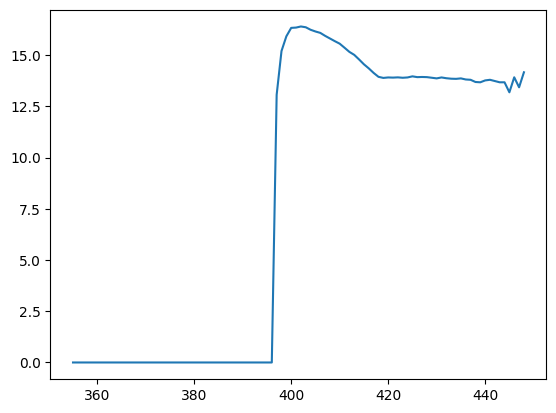

In [177]:
plt.figure()
plt.plot(vol_dates['Fecha 6']['Volatilidad Implícita'])